# Przewidywanie spożycia alkoholu przez studentów z wykorzystaniem prostej sieci nauronowej
## Analiza Zbioru danych
Dane omawiane w niniejszym dokumencie pobrane są ze strony https://www.kaggle.com/uciml/student-alcohol-consumption  
Zawierają one wyniki ankiety przeprowadzonej pośród studentów dwóch kursów: matematyki oraz portugalskiego. Podczas ankiety zebrano wiele danych o respondentach takie jak, wiek, oceny, rozmiar rodziny, czy też średnie spożycie alkoholu, które będzie przedmiotem niniejszej analizy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import check_output

math_class_data = pd.read_csv(os.path.abspath('') + "/data/student-mat.csv", delimiter=";")
port_class_data = pd.read_csv(os.path.abspath('') + "/data/student-por.csv", delimiter=";")
data = math_class_data.append(port_class_data)
data = data[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
            'reason', 'guardian', 'traveltime', 'studytime',
            'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
            'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
            'Walc', 'health', 'absences', 'G1', 'G2', 'G3']]
numeric_values = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                  'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
binary_values = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup',
                 'famsup', 'paid', 'higher', 'activities', 'nursery', 'internet', 'romantic']
nominal_values = ['reason', 'guardian']
data


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,reason,guardian,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,course,mother,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,course,father,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,other,mother,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,home,mother,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,home,father,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,course,mother,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,course,mother,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,course,mother,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,course,mother,...,2,4,5,3,4,2,6,10,10,10


Pozwoliliśmy sobie na połaćzenie danych z dwóch kursów, ponieważ różnice wynikające z możliwych różnic w poziomach trudności (a co za tym idzie ocen) sa minimalne.  
Usunięte także zostały kolumny dotyczące pracy rodziców, ponieważ te dane niewiele wnoszą do modelu, a ich znaczenie jest marginalne. Należy także wziąć pod uwagę, że te kategorie są dość ogólne.  
Dane ną pełne, nie ma tu pustych komórek, co ułatwi trening sieci.  
Mamy tu ponad 1000 rekodrów, co wg informacji z wykładu powinno pozwolić na wytrenowanie sieci zawierającej (w przubliżeniu) do 100 neuronów.

W zbiorze danych mamy do czynienia z dwoma typami parametrów:
- liczbowe - wiek, wyniki ocen
- binarne - wsparcie rodziny, branie dodatkowych aktywności
- nominalne - płeć, miejsce zamieszkania, powód wybrania kursu

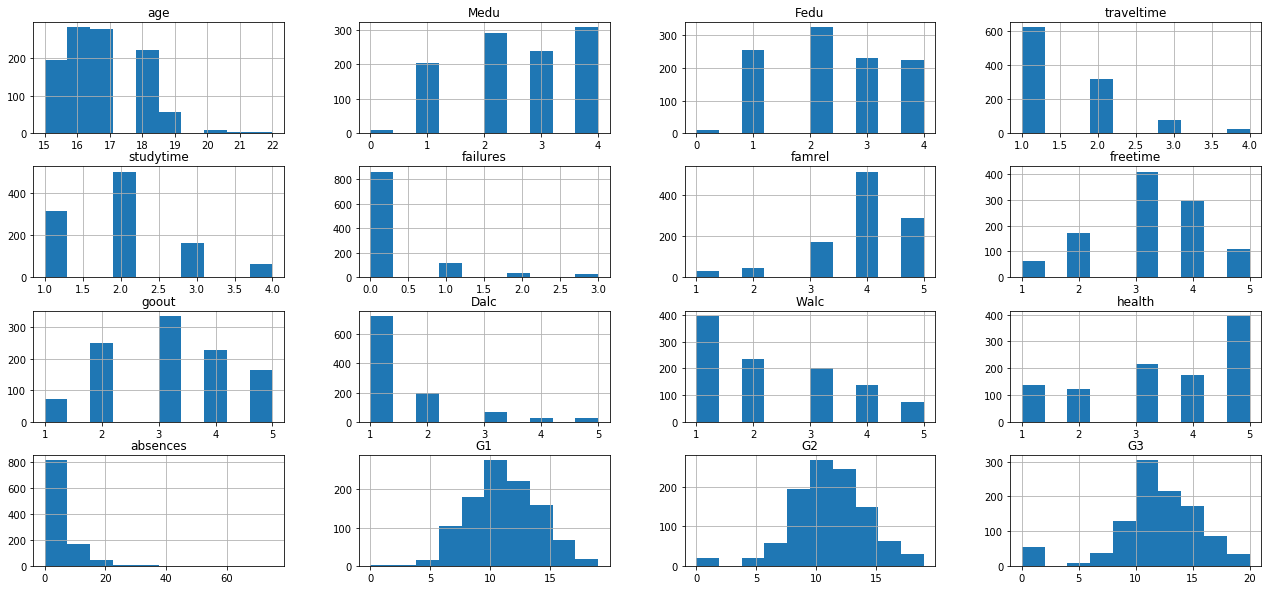

In [2]:
x = data[numeric_values].hist(figsize=(22,10),ylabelsize=10)

In [3]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (3 * nGraphPerRow, 3 * nGraphRow), dpi = 80)
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]}')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

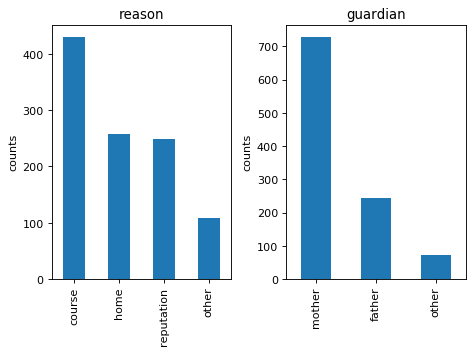

In [4]:
plotPerColumnDistribution(data[nominal_values],2,2)

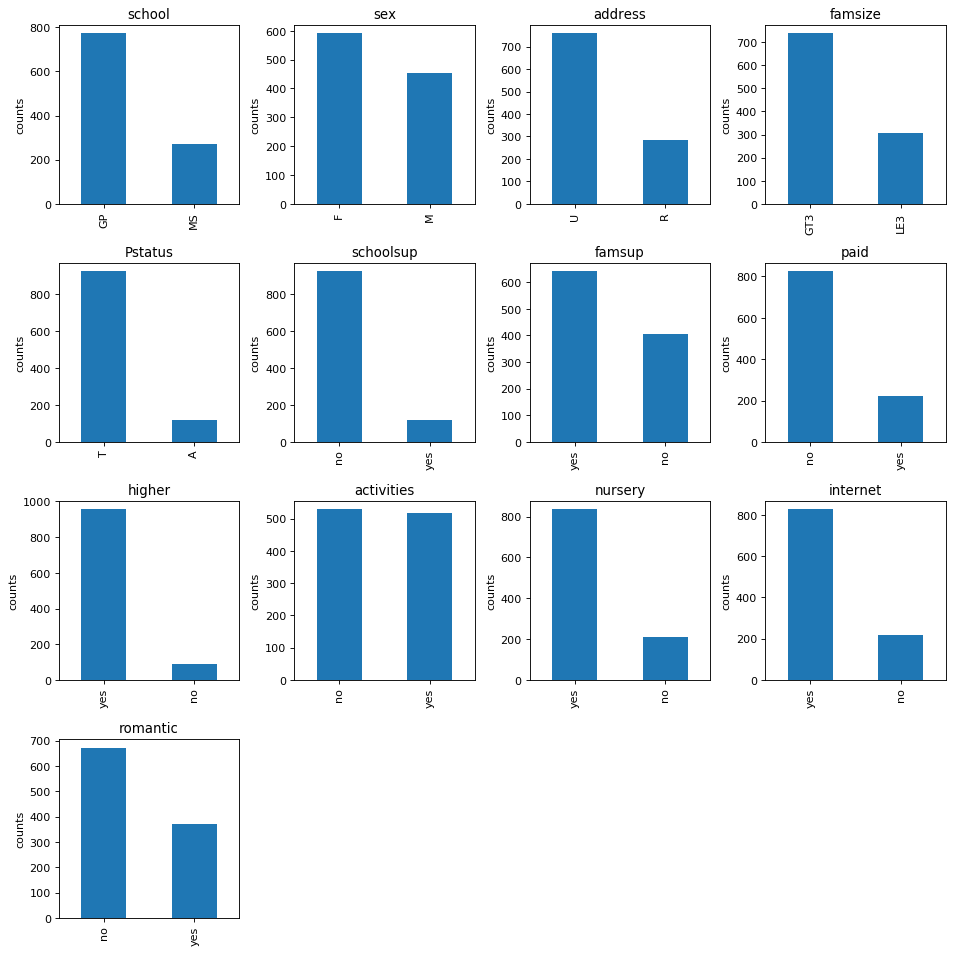

In [5]:
plotPerColumnDistribution(data[binary_values], len(binary_values), 4)

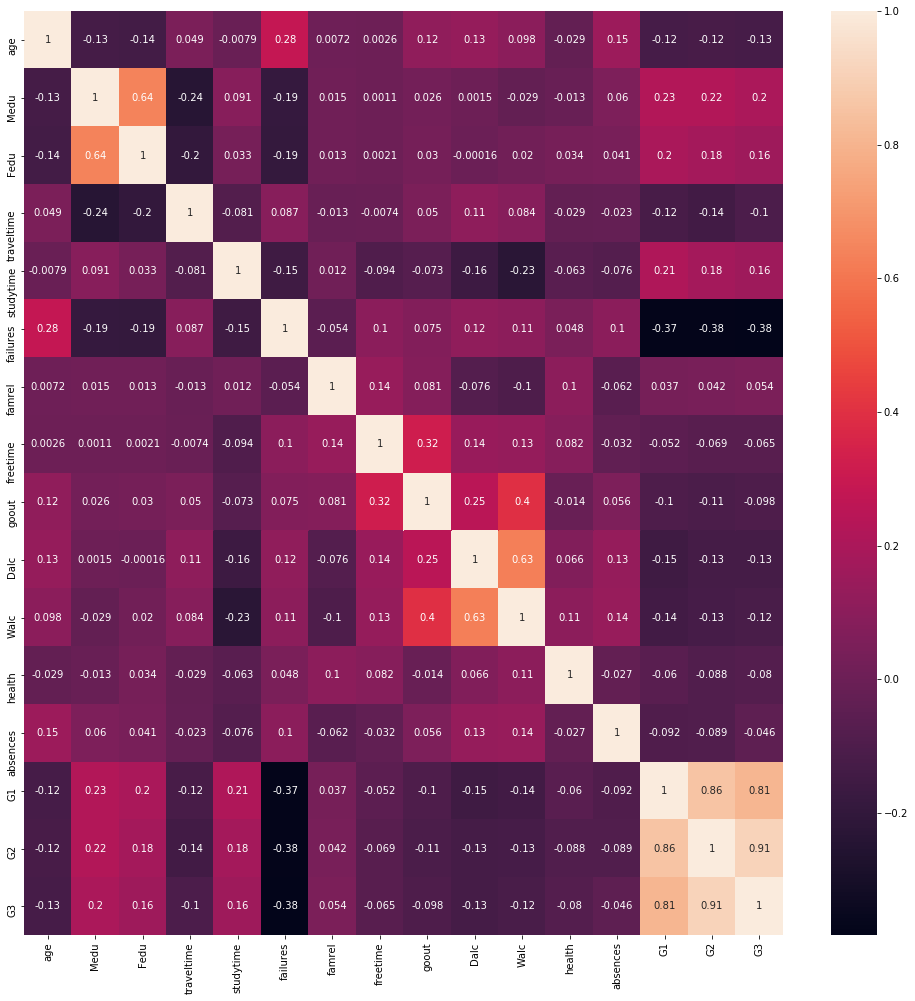

In [16]:
import seaborn as sns
plt.figure(figsize=(17,17))
sns.heatmap(data.corr(),annot = True)

Z powyższej mapy korelacji można wywnioskować pewne prostsze zależności dotyczące spożycia alkoholu wśród uczestników kursu.  
Można zauważyć, że spożycie alkoholu jest proporcjonalne do częstotliwości wyjść, zaś odwrotnie proporcjonalne do ilości czasu spędzonego na nauce.